## Example 3D stitching workflow

This notebook uses the 3D example dataset provided by BigStitcher: https://imagej.net/plugins/bigstitcher/#example-datasets.

This notebook
1) downloads the example dataset (6 tiles, 3 channels)
2) converts its tif files into OME-Zarr files, which include translation metadata placing the input tiles onto a regular grid (serving as an approximate starting point for the registration)
3) registers the tiles using one of the input channels
4) displays the obtained transformation parameters
5) fuses the tiles into a single image (average fusion with blending between tiles)
6) saves the fused image in OME-Zarr and tif formats

Notes:
- `napari-stitcher` is required for visualization functionality

In [12]:
# imports

import os
import zipfile
from pathlib import Path

import dask.diagnostics
import ngff_zarr
import numpy as np
import tifffile
from multiview_stitcher import (
    fusion,
    io,
    msi_utils,
    ngff_utils,
    param_utils,
    registration,
    spatial_image_utils,
)
from tqdm import tqdm

# napari-stitcher is required for visualization with napari
VISUALIZE_USING_NAPARI = False

if VISUALIZE_USING_NAPARI:
    import napari
    from napari_stitcher import viewer_utils

## Download example data

In [13]:
url = "https://preibischlab.mdc-berlin.de/BigStitcher/Grid_3d.zip"

base_dir = './%s' %os.path.basename(url)[:-4]
os.makedirs(base_dir, exist_ok=True)

zip_filepath = os.path.join(base_dir, os.path.basename(url))

# download
if not os.path.exists(zip_filepath):
    from urllib.request import urlretrieve
    urlretrieve(url, zip_filepath)

# unzip
with zipfile.ZipFile(os.path.join(base_dir, os.path.basename(url)), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

# get the list of files
sorted(Path(base_dir).glob('*/*.tif'))

[PosixPath('Grid_3d/Grid1/C1-73.tif'),
 PosixPath('Grid_3d/Grid1/C1-74.tif'),
 PosixPath('Grid_3d/Grid1/C1-75.tif'),
 PosixPath('Grid_3d/Grid1/C1-76.tif'),
 PosixPath('Grid_3d/Grid1/C1-77.tif'),
 PosixPath('Grid_3d/Grid1/C1-78.tif'),
 PosixPath('Grid_3d/Grid1/C2-73.tif'),
 PosixPath('Grid_3d/Grid1/C2-74.tif'),
 PosixPath('Grid_3d/Grid1/C2-75.tif'),
 PosixPath('Grid_3d/Grid1/C2-76.tif'),
 PosixPath('Grid_3d/Grid1/C2-77.tif'),
 PosixPath('Grid_3d/Grid1/C2-78.tif'),
 PosixPath('Grid_3d/Grid1/C3-73.tif'),
 PosixPath('Grid_3d/Grid1/C3-74.tif'),
 PosixPath('Grid_3d/Grid1/C3-75.tif'),
 PosixPath('Grid_3d/Grid1/C3-76.tif'),
 PosixPath('Grid_3d/Grid1/C3-77.tif'),
 PosixPath('Grid_3d/Grid1/C3-78.tif')]

## Specify input files

In [14]:
# indicate the tiles and channels to process
tiles = np.arange(73, 79)
channels = np.arange(1, 4)

def get_filename_from_tile_and_channel(tile, channel):
    """
    This convenience function returns the filename given the tile and channel.
    """
    return f'./Grid_3d/Grid1/C{channel:01d}-{tile:02d}.tif'

print('Example filename:\n', get_filename_from_tile_and_channel(tiles[0], channels[0]))

Example filename:
 ./Grid_3d/Grid1/C1-73.tif


## Read input data and convert to OME-Zarr

- this includes (pre-)arranging the tiles on a grid

In [15]:
overwrite = True

msims = []
for tile_index, tile in tqdm(enumerate(tiles[:])):

    # where to save the zarr(s)
    zarr_path = os.path.join(os.path.dirname(get_filename_from_tile_and_channel(tile, channels[0])),
                             f'tile_{tile:02d}')

    # if zarr doesn't exist yet, create it
    if not os.path.exists(zarr_path) or overwrite:

        # indicate pixel spacing
        scale = {'z': 5, 'y': 1, 'x': 1}

        # indicate grid position for current tile index
        # (as a function of the tile index)
        tile_grid_positions = {
            'z': 0,
            'y': tile_index // 2,
            'x': tile_index % 2,
        }

        # indicate approximate overlap between tiles
        overlap = 0.1

        # read tile image
        im_data = np.array([
            tifffile.imread(get_filename_from_tile_and_channel(tile, ch))
            for ch in channels])

        shape = {dim: im_data.shape[-idim] for idim, dim in enumerate(scale.keys())}
        translation = {dim: tile_grid_positions[dim] * (1 - overlap) * shape[dim] * scale[dim]
                    for dim in scale}

        ngff_im = ngff_zarr.NgffImage(
            im_data,
            dims=('c', 'z', 'y', 'x'),
            scale=scale,
            translation=translation,
            )

        ngff_multiscales = ngff_zarr.to_multiscales(ngff_im)

        ngff_zarr.to_ngff_zarr(zarr_path, ngff_multiscales)

    # open tile image from zarr on disk
    msim = ngff_utils.ngff_multiscales_to_msim(
        ngff_zarr.from_ngff_zarr(zarr_path),
        transform_key=io.METADATA_TRANSFORM_KEY)

    msims.append(msim)

6it [00:12,  2.16s/it]


In case of starting from OME-Zarr data, skip the previous cell and read input data as follows:

In [ ]:
# # Input file names
# zarr_tile_paths = ['tile1.zarr', 'tile2.zarr']

# msims = [
#     ngff_utils.ngff_multiscales_to_msim(
#         ngff_zarr.from_ngff_zarr(zarr_tile_path),
#         transform_key=io.METADATA_TRANSFORM_KEY
#         )
#         for zarr_tile_path in zarr_tile_paths]

### Visualize pre-registered views

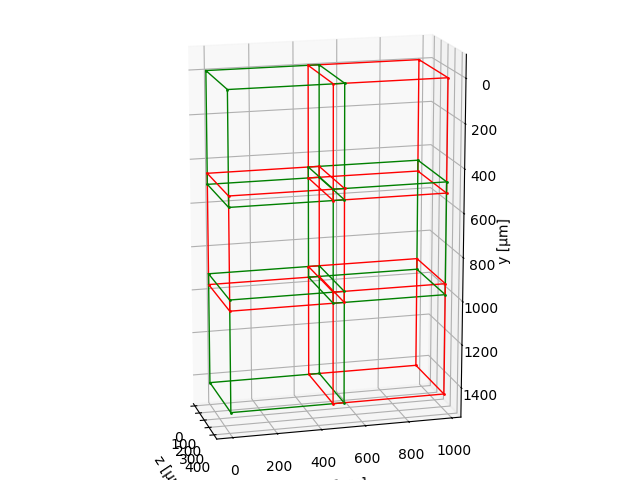

In [16]:
# visualize tile positions/configuration

# uncomment the following line for 3D interactivity with
# the plot (requires ipympl to be installed)

# % matplotlib widget

from multiview_stitcher import vis_utils

fig, ax = vis_utils.plot_positions(
    msims,
    use_positional_colors=True, # set to False for faster execution in case of more than 20 tiles/views
    transform_key='affine_metadata'
    )

In [17]:
# using napari

if VISUALIZE_USING_NAPARI:

    ch_coord = 0 # None if all should be shown

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))
    lds = viewer_utils.create_image_layer_tuples_from_msims(
        msims, ch_coord=ch_coord, transform_key='affine_metadata', n_colors=2, contrast_limits=[0, 500])
    viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)
    viewer.reset_view()


### Register views

In [18]:
# import skimage.registration

with dask.diagnostics.ProgressBar():

    params = registration.register(
        msims,
        # registration_binning={'z': 2, 'y': 8, 'x': 8},
        reg_channel_index=0,
        transform_key='affine_metadata',
    )

for msim, param in zip(msims, params):
    msi_utils.set_affine_transform(msim, param, transform_key='affine_registered', base_transform_key='affine_metadata')

[########################################] | 100% Completed | 9.39 sms


In [19]:
# print the obtained parameters
# how to interpret these?
#   - parameters are expressed in homogeneous matrices of dimensions (n+1, n+1)
#   - the first n rows and columns correspond to the linear part of the transformation
#   - the first three elements of the last column correspond to the translation in (z, y, x)
#   - the parameters map the coordinates of the input files (considering their scale and translation)
#     into a world coordinate system in which the tiles are registered

for imsim, msim in enumerate(msims):
    affine = np.array(msi_utils.get_transform_from_msim(msim, transform_key='affine_registered')[0])
    print(f'tile index {imsim}\n', affine)

tile index 0
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   5.5]
 [ 0.   0.   1.  -2.5]
 [ 0.   0.   0.   1. ]]
tile index 1
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   5.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]
tile index 2
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -1.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]
tile index 3
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
tile index 4
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -3. ]
 [ 0.   0.   1.  -1.5]
 [ 0.   0.   0.   1. ]]
tile index 5
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -4.5]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]


### Visualize registration

In [20]:
if VISUALIZE_USING_NAPARI:

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

    ch_coord = 0 # None if all should be shown

    lds = viewer_utils.create_image_layer_tuples_from_msims(
        msims, ch_coord=ch_coord, transform_key='affine_registered', n_colors=2,
        name_prefix='registered view',
        contrast_limits=[0, 500],
        )
    rlayers = viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds, do_link_layers=True)

    viewer.reset_view()

### Fuse views (linear blending)
#### Save output into OME-Zarr

In [21]:
sims = [msi_utils.get_sim_from_msim(msim) for msim in msims]

output_dir = base_dir
output_filename = os.path.join(output_dir, 'fused.zarr')

fused = fusion.fuse(
    sims[:],
    transform_key='affine_registered',
    output_chunksize=256,
    )

print(f'Fusing views and saving output to {output_filename}...')
with dask.diagnostics.ProgressBar():

    fused_ngff = ngff_utils.sim_to_ngff_image(
        fused,
        transform_key='affine_registered')

    fused_ngff_multiscales = ngff_zarr.to_multiscales(fused_ngff, scale_factors=[])

    ngff_zarr.to_ngff_zarr(
        output_filename,
        fused_ngff_multiscales,
        )

mfused = ngff_utils.ngff_multiscales_to_msim(
    ngff_zarr.from_ngff_zarr(output_filename),
    transform_key='affine_registered')


Fusing views and saving output to ./Grid_3d/fused.zarr...
[########################################] | 100% Completed | 28.28 s


### Visualize fusion in napari

In [22]:
if VISUALIZE_USING_NAPARI:

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

    ch_coord = None

    lds = viewer_utils.create_image_layer_tuples_from_msims(
        [mfused],
        ch_coord=ch_coord,
        transform_key='affine_registered',
        name_prefix='fused',
        contrast_limits=[0, 500])

    viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)

In [23]:
# stream fused image into tif
# i.e. convert OME-Zarr output into tif

output_filename = os.path.join(output_dir, 'fused.tif')

print(f'Streaming into {output_filename}...')

with dask.diagnostics.ProgressBar():
    io.save_sim_as_tif(
        output_filename,
        msi_utils.get_sim_from_msim(mfused))

Streaming into ./Grid_3d/fused.tif...


  0%|          | 0/3 [00:00<?, ?it/s]

[########################################] | 100% Completed | 429.60 ms


 33%|███▎      | 1/3 [00:00<00:01,  1.88it/s]

[########################################] | 100% Completed | 425.63 ms


 67%|██████▋   | 2/3 [00:01<00:00,  1.92it/s]

[########################################] | 100% Completed | 521.65 ms


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
